In [1]:
import cv2
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To read dataset

In [3]:
dir_path = '/content/drive/MyDrive/Garbage classification'
target_size = (224, 224)
waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
num_classes = len(waste_labels)

In [4]:
def load_datasets(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)

        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])

    x, labels = shuffle(x, labels, random_state=42)
    labels = to_categorical(labels, num_classes=num_classes)  # One-hot encoding

    print(f"x size: {np.array(x).shape}")
    print(f"Number of label classes: {num_classes} | Number of observations: {len(labels)}")
    return np.array(x), np.array(labels)

x, labels = load_datasets(dir_path)

x size: (2527, 224, 224, 3)
Number of label classes: 6 | Number of observations: 2527


In [5]:
input_shape = (target_size[0], target_size[1], 3)
print(f"Input shape: {input_shape}")

Input shape: (224, 224, 3)


To visualize images

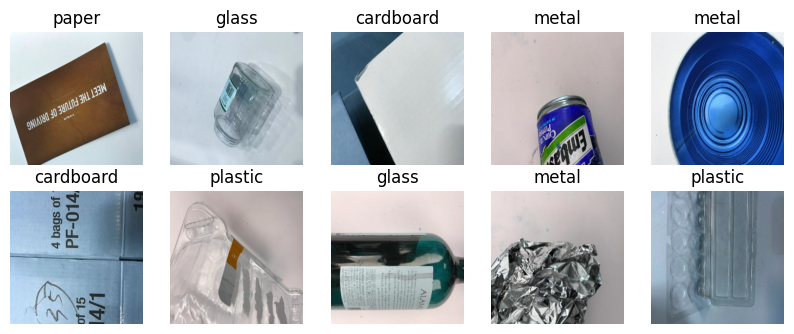

In [6]:
def visualize_img(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(10):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        label_index = np.argmax(label_batch[n])  # Decode one-hot encoded label
        label_name = list(waste_labels.keys())[label_index]
        plt.title(label_name)
        plt.axis('off')

visualize_img(x, labels)

Data Preparation

In [7]:
train_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_gen = ImageDataGenerator(rescale=1/255, validation_split=0.1)

In [8]:
train_generator = train_gen.flow(x, labels, subset="training", batch_size=32)
test_generator = train_gen.flow(x, labels, subset="validation", batch_size=32)


Modelling

In [9]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=2, strides=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Optimization

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
)

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
    ModelCheckpoint(filepath="mymodel.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
]

Model Tuning

In [13]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1965 - loss: 1.7815 - precision: 0.3944 - recall: 0.0034
Epoch 1: val_loss improved from inf to 1.70623, saving model to mymodel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.1967 - loss: 1.7813 - precision: 0.3945 - recall: 0.0034 - val_accuracy: 0.2500 - val_loss: 1.7062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2246 - loss: 1.7436 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 1.70623 to 1.70068, saving model to mymodel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.2245 - loss: 1.7435 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.7007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


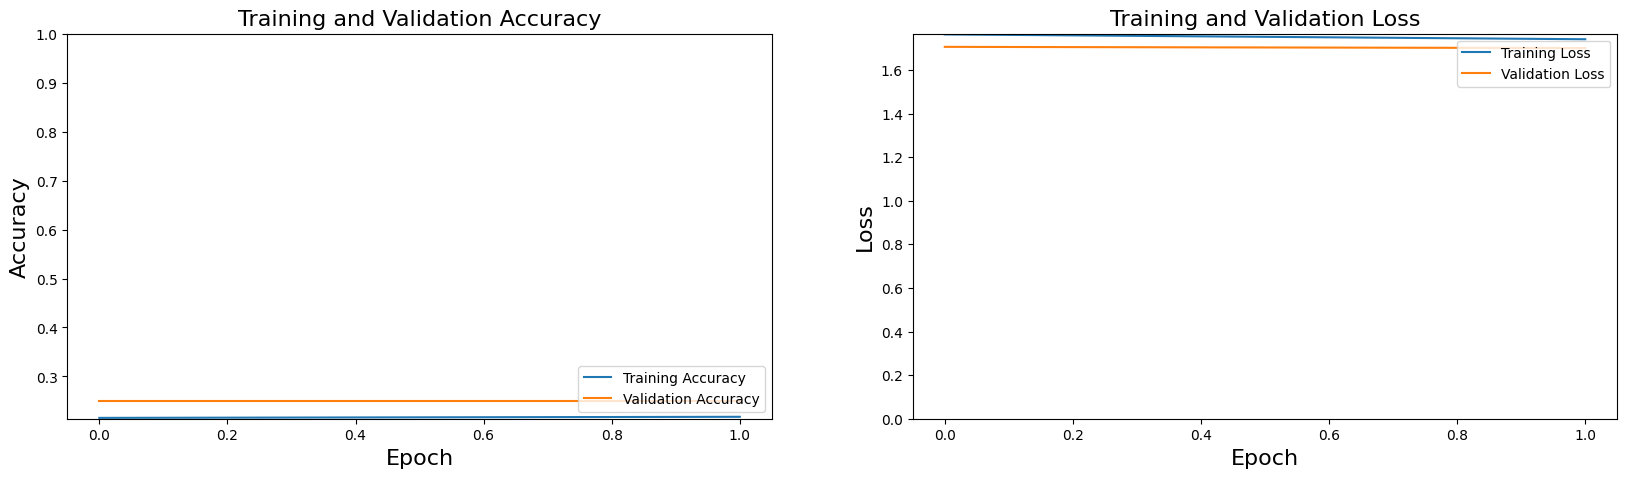

In [26]:
#Graph of accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy", fontsize=16)

#Graph of loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

Evaluation

In [27]:
loss, precision, recall, acc= model.evaluate(test_generator, batch_size=32)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2456 - loss: 1.7123 - precision: 0.0000e+00 - recall: 0.0000e+00


In [28]:
print("\nTest accuracy: %.lf%%"% (100*acc))
print("\nTest loss: %.lf%%"% (100*loss))
print("\nTest precision: %.lf%%"% (100*precision))
print("\nTest recall: %.lf%%"% (100* recall))


Test accuracy: 25%

Test loss: 170%

Test precision: 0%

Test recall: 0%


In [29]:
#Classification report
x_test, y_test = test_generator.__next__()
y_pred = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [30]:
y_pred

array([[0.16190776, 0.17943484, 0.16969597, 0.23402546, 0.1968847 ,
        0.05805128],
       [0.16290163, 0.18110082, 0.16526511, 0.22840096, 0.18893144,
        0.07340004],
       [0.16476956, 0.18302287, 0.1609308 , 0.20659885, 0.1781531 ,
        0.10652486],
       [0.16742708, 0.18561661, 0.16386032, 0.20576334, 0.18010883,
        0.09722368],
       [0.16284099, 0.17972158, 0.16483451, 0.23164147, 0.19034645,
        0.07061491],
       [0.16548528, 0.18363282, 0.16324583, 0.19549617, 0.17594802,
        0.11619184],
       [0.15901463, 0.17695634, 0.17043462, 0.2338925 , 0.19967993,
        0.06002191],
       [0.16511476, 0.1835699 , 0.1605758 , 0.20221014, 0.17661668,
        0.11191279],
       [0.16437519, 0.1820114 , 0.16400497, 0.2196291 , 0.18652357,
        0.08345573],
       [0.16606611, 0.18457547, 0.1624711 , 0.19534503, 0.17561233,
        0.11592993],
       [0.15863632, 0.17429984, 0.17123169, 0.23256157, 0.19765688,
        0.06561377],
       [0.16614622, 0

In [31]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [32]:
target_names= list(waste_labels.keys())

In [33]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00         5
       glass       0.00      0.00      0.00         7
       metal       0.00      0.00      0.00         5
       paper       0.16      1.00      0.27         5
     plastic       0.00      0.00      0.00         9
       trash       0.00      0.00      0.00         1

    accuracy                           0.16        32
   macro avg       0.03      0.17      0.05        32
weighted avg       0.02      0.16      0.04        32



In [47]:
import itertools
cm = confusion_matrix(y_test, y_pred)
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)  # plt_xticks -> plt.xticks
    plt.yticks(tick_marks, classes)              # plt_yticks -> plt.yticks

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontweight="bold")
    plt.xlabel('Predicted Label', fontweight="bold")


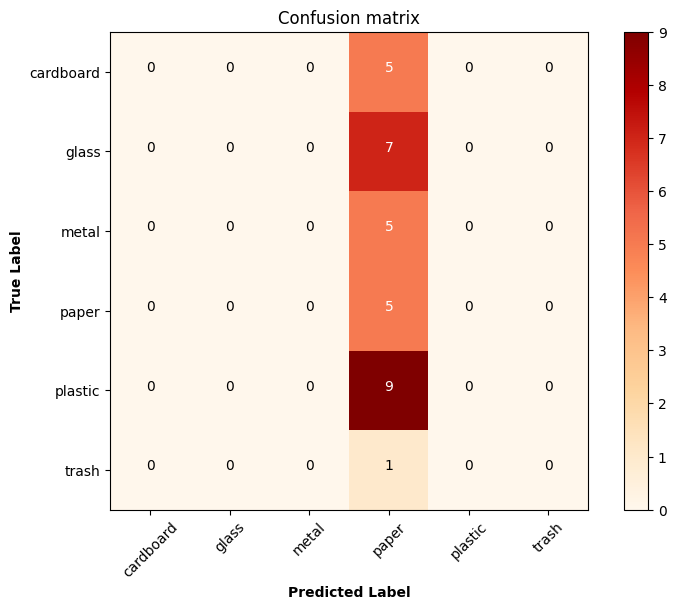

In [48]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix', cmap=plt.cm.OrRd)

In [49]:
waste_labels = {
    0: 'cardboard',
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic',
    5: 'trash'
}

# Model test fonksiyonu
def model_testing(path, model, target_size=(224, 224)):
    # Görüntüyü yükleme ve ön işleme
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0  # Görüntüyü normalize et

    # Tahmin yapma
    p = model.predict(img.reshape(1, target_size[0], target_size[1], 3))
    predicted_class = np.argmax(p[0])

    return img, p, predicted_class


In [52]:
img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage classification/Garbage classification/metal/metal100.jpg', model)
img2, p2, predicted_class2 = model_testing('/content/drive/MyDrive/Garbage classification/Garbage classification/glass/glass105.jpg', model)
img3, p3, predicted_class3 = model_testing('/content/drive/MyDrive/Garbage classification/Garbage classification/cardboard/cardboard103.jpg', model)
img4, p4, predicted_class4 = model_testing('/content/drive/MyDrive/Garbage classification/Garbage classification/paper/paper106.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


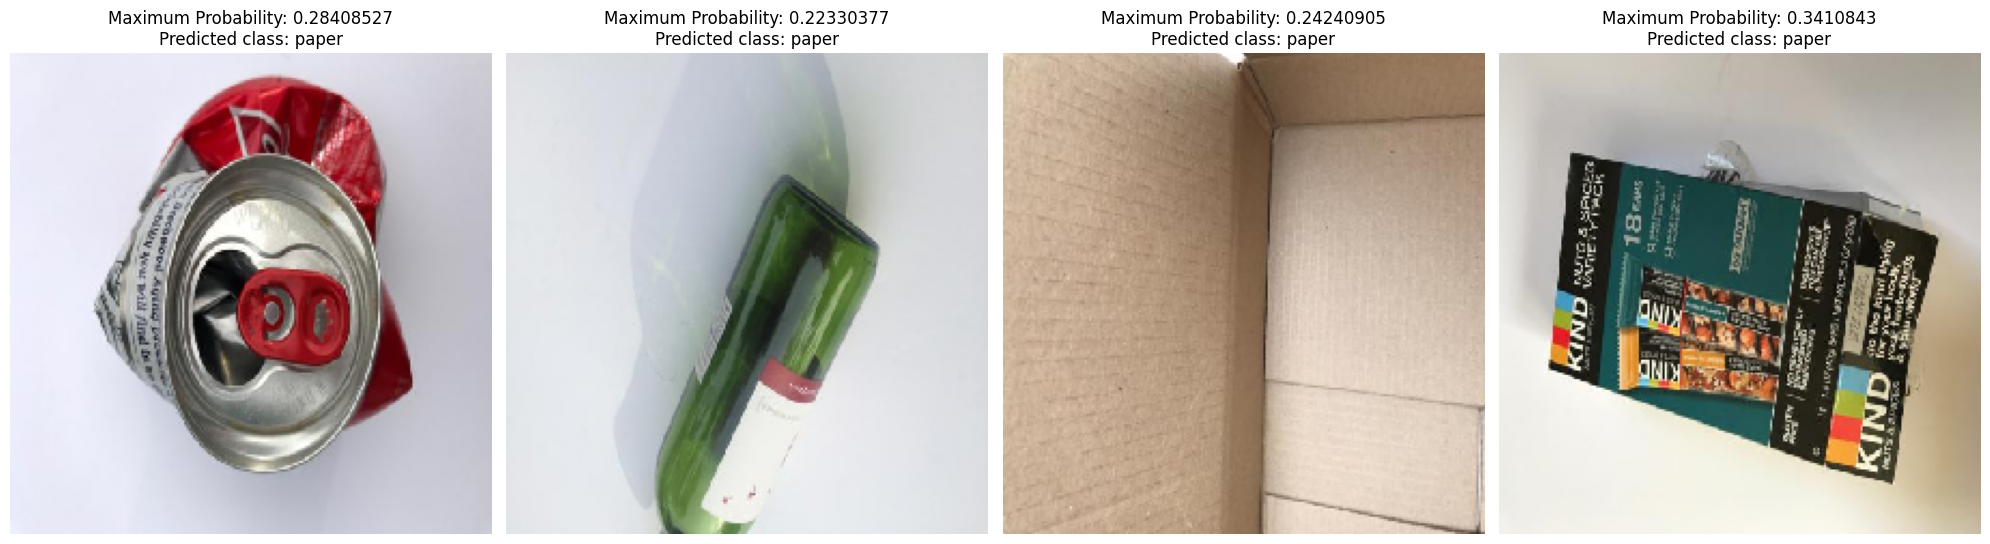

In [53]:
plt.figure(figsize=(20, 60))

# Görüntü 1
plt.subplot(141)  # 1 satır, 4 sütun, 1. görsel
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title(
    "Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" +
    "Predicted class: " + str(waste_labels[predicted_class1])
)

# Görüntü 2
plt.subplot(142)  # 1 satır, 4 sütun, 2. görsel
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title(
    "Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" +
    "Predicted class: " + str(waste_labels[predicted_class2])
)

# Görüntü 3
plt.subplot(143)  # 1 satır, 4 sütun, 3. görsel
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title(
    "Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" +
    "Predicted class: " + str(waste_labels[predicted_class3])
)

# Görüntü 4
plt.subplot(144)  # 1 satır, 4 sütun, 4. görsel
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title(
    "Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" +
    "Predicted class: " + str(waste_labels[predicted_class4])
)

plt.tight_layout()
plt.show()
